# Train different kinds of masks over IOI edges

In [1]:
from models import load_gpt2_weights, load_demo_gpt2, tokenizer
from data import retrieve_toxic_data, retrieve_owt_data, retrieve_toxic_data_low_loss, retrieve_toxic_filtered_data, FILTER_DEMO_LEN, CONTEXT_LENGTH
from inference import infer_batch_with_owt, infer_batch, prepare_fixed_demo, criterion
from torch.optim import AdamW
import torch
import pickle
import datasets
from tqdm import tqdm_notebook as tqdm
from itertools import cycle
from eval import evaluate_model
from data import batch_text_to_tokens
import plotly.express as px

Using device: cuda:0


In [4]:
toxic_batch_size = 1 # so that we can just access the last sequence position without worrying about padding
owt_batch_size = 5
context_length = CONTEXT_LENGTH

toxic_data_loader = retrieve_toxic_data(toxic_batch_size, context_length, tokenizer, tokenize=False, num_points=None)
# toxic_data_loader = retrieve_toxic_filtered_data(toxic_batch_size)
owt_data_loader = retrieve_owt_data(owt_batch_size)

with open("data/gpt2_means.pkl", "rb") as f:
    means = pickle.load(f)[0][0]

model = load_demo_gpt2(means=False)
epochs_left = 200
log_every = 20
lr = .05 # free
weight_decay = 0
clamp_every = 20 # 5 # free
threshold = 0.5
epochs_trained = 0
regularization_strength = 1 # free

mask_params = []
param_names = []
for name, p in model.named_parameters():
    if p.requires_grad:
        param_names.append(name)
        mask_params.append(p)
optimizer = AdamW(mask_params, lr=lr, weight_decay=weight_decay)

losses = []
num_ablated_edges = []
alpha = 0.2 # free
batch_size = toxic_batch_size + owt_batch_size
demos = prepare_fixed_demo(tokenizer, batch_size, demo="")
owt_iter = cycle(owt_data_loader)
edge_threshold = 100
max_steps_per_epoch = 100


## Train params of mask
Train without the original D_train loss term (only mask loss and IOI data loss)
Finds necessary (but not sufficient) edges

In [5]:
old_mask_params = {}
def duplicate_mask_params(mask_params):
    new_mask_params = []
    for p in mask_params:
        new_mask_params.append(p.data.cpu())
    return new_mask_params

prev_params = None
while epochs_left >= 0:
    for e in tqdm(range(epochs_left)):
        for c, batch in enumerate(toxic_data_loader):
            if c > max_steps_per_epoch:
                break

            # print(batch["text"])
            total_preserving = 0
            ablated_edges = 0
            penalty = 0
            for p in mask_params:
                total_preserving += p.sum()
                ablated_edges += p[p.data < 0.5].shape[0]
                penalty += max(0, p.sum() * (epochs_trained-20) / 10000) # why 2000? free

            # demos = batch[:, :FILTER_DEMO_LEN]
            # completions = batch[:, FILTER_DEMO_LEN:]

            # tox_loss = infer_batch(model, criterion, completions, toxic_batch_size, demos)
            # owt_loss = infer_batch(model, criterion, next(owt_iter)['tokens'], owt_batch_size, fixed_demos)
            tox_loss, owt_loss = infer_batch_with_owt(model, criterion, batch, next(owt_iter), batch_size, demos, access_toxic_pos=-1)
            # print(f"{tox_loss=}, {owt_loss=}")
            loss = -1 * (regularization_strength * penalty + alpha * tox_loss) #+ owt_loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            num_ablated_edges.append(ablated_edges)
            for p in mask_params:
                p.data.clamp_(0,1)
        print(f"{loss.item()=}, {ablated_edges=}")
        epochs_trained += 1
        if epochs_trained % clamp_every == 0:
            ablated_edges = 0
            for p in mask_params:
                p.data[p.data < threshold] = 0
                p.data[p.data >= threshold] = 1
                ablated_edges += p[p.data < 0.5].shape[0]
        if epochs_trained % log_every == 0:
            print("Epochs trained: ", epochs_trained)
            print(f"Loss: {loss.item():.4f}")
            print(f"Total preserved: {total_preserving:.4f}")
            print("Edges ablated: ", ablated_edges)
            print("Toxic loss: ", tox_loss.item())
            print("OWT loss: ", owt_loss.item())
            print("Penalty: ", penalty)
            # if input('evaluate? (y)') == 'y':
            #     evaluate_model(model, toxic_batches=1, owt_batches=1)
            print("\n")
            old_mask_params[epochs_trained] = duplicate_mask_params(mask_params)
                
        if epochs_trained > 50 and ablated_edges < edge_threshold:
            break
        prev_params = mask_params
    epochs_left = int(input('continue training for this number of epochs: '))
    log_every = int(input('set log frequency'))
    edge_threshold = int(input('set edge threshold'))

/tmp/ipykernel_20895/790077214.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm(range(epochs_left)):


  0%|          | 0/200 [00:00<?, ?it/s]

loss.item()=-20.122053146362305, ablated_edges=2915
loss.item()=-20.068288803100586, ablated_edges=3843
loss.item()=-21.689908981323242, ablated_edges=4396
loss.item()=-17.28571128845215, ablated_edges=4792
loss.item()=-22.21891212463379, ablated_edges=4990
loss.item()=-21.7319278717041, ablated_edges=5183
loss.item()=-19.91407585144043, ablated_edges=5354
loss.item()=-20.44097137451172, ablated_edges=5518
loss.item()=-20.397144317626953, ablated_edges=5561
loss.item()=-21.941560745239258, ablated_edges=5660
loss.item()=-21.839719772338867, ablated_edges=5744
loss.item()=-21.898679733276367, ablated_edges=5777
loss.item()=-21.012075424194336, ablated_edges=5815
loss.item()=-21.68058204650879, ablated_edges=5903
loss.item()=-22.401411056518555, ablated_edges=5927
loss.item()=-22.71929168701172, ablated_edges=5960
loss.item()=-23.051502227783203, ablated_edges=6021
loss.item()=-20.667556762695312, ablated_edges=6015
loss.item()=-19.387042999267578, ablated_edges=5981
loss.item()=-22.8468

ValueError: invalid literal for int() with base 10: ''

In [21]:
with open("models/alternative_necessary_masks_params_dict_lambda=1.pkl", "wb") as f:
    pickle.dump(old_mask_params, f)

## Different alternative: sufficient but not necessary
Trains with an inverted loss function. This loss function encourages sparsity (as opposed to discouraging) and wants model to ablate everything but the necessary circuit.

In [24]:
toxic_batch_size = 1 # so that we can just access the last sequence position without worrying about padding
owt_batch_size = 1
context_length = CONTEXT_LENGTH

toxic_data_loader = retrieve_toxic_data(toxic_batch_size, context_length, tokenizer, tokenize=False, num_points=None)
# toxic_data_loader = retrieve_toxic_filtered_data(toxic_batch_size)
owt_data_loader = retrieve_owt_data(owt_batch_size)

with open("data/gpt2_means.pkl", "rb") as f:
    means = pickle.load(f)[0][0]

model = load_demo_gpt2(means=False)
epochs_left = 200
log_every = 20
lr = .05 # free
weight_decay = 0
clamp_every = 20 # 5 # free
threshold = 0.5
epochs_trained = 0
regularization_strength = 1 # free

mask_params = []
param_names = []
for name, p in model.named_parameters():
    if p.requires_grad:
        param_names.append(name)
        mask_params.append(p)
optimizer = AdamW(mask_params, lr=lr, weight_decay=weight_decay)

losses = []
num_ablated_edges = []
alpha = 0.2 # free
batch_size = toxic_batch_size + owt_batch_size
demos = prepare_fixed_demo(tokenizer, batch_size, demo="")
owt_iter = cycle(owt_data_loader)
edge_threshold = 100
max_steps_per_epoch = 100


old_mask_params = {}
def duplicate_mask_params(mask_params):
    new_mask_params = []
    for p in mask_params:
        new_mask_params.append(p.data.cpu())
    return new_mask_params

prev_params = None
while epochs_left >= 0:
    for e in tqdm(range(epochs_left)):
        for c, batch in enumerate(toxic_data_loader):
            if c > max_steps_per_epoch:
                break

            # print(batch["text"])
            total_preserving = 0
            ablated_edges = 0
            penalty = 0
            for p in mask_params:
                total_preserving += p.sum()
                ablated_edges += p[p.data < 0.5].shape[0]
                penalty += max(0, p.sum() * (epochs_trained-20) / 10000) # why 2000? free

            tox_loss, owt_loss = infer_batch_with_owt(model, criterion, batch, next(owt_iter), batch_size, demos, access_toxic_pos=-1)
            # print(f"{tox_loss=}, {owt_loss=}")
            loss = regularization_strength * penalty + alpha * tox_loss # inverted loss function #+ owt_loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            num_ablated_edges.append(ablated_edges)
            for p in mask_params:
                p.data.clamp_(0,1)
        print(f"{loss.item()=}, {ablated_edges=}")
        epochs_trained += 1
        if epochs_trained % clamp_every == 0:
            ablated_edges = 0
            for p in mask_params:
                p.data[p.data < threshold] = 0
                p.data[p.data >= threshold] = 1
                ablated_edges += p[p.data < 0.5].shape[0]
        if epochs_trained % log_every == 0:
            print("Epochs trained: ", epochs_trained)
            print(f"Loss: {loss.item():.4f}")
            print(f"Total preserved: {total_preserving:.4f}")
            print("Edges ablated: ", ablated_edges)
            print("Toxic loss: ", tox_loss.item())
            print("OWT loss: ", owt_loss.item())
            print("Penalty: ", penalty)
            # if input('evaluate? (y)') == 'y':
            #     evaluate_model(model, toxic_batches=1, owt_batches=1)
            print("\n")
            old_mask_params[epochs_trained] = duplicate_mask_params(mask_params)
                
        if epochs_trained > 50 and ablated_edges < edge_threshold:
            break
        prev_params = mask_params

    epochs_left = -1
    # epochs_left = int(input('continue training for this number of epochs: '))
    # log_every = int(input('set log frequency'))
    # edge_threshold = int(input('set edge threshold'))

/tmp/ipykernel_20895/4196007447.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm(range(epochs_left)):


  0%|          | 0/200 [00:00<?, ?it/s]

loss.item()=3.0994391408967203e-07, ablated_edges=2239
loss.item()=0.0035884298849850893, ablated_edges=2876
loss.item()=0.004196183290332556, ablated_edges=3844
loss.item()=0.0009174016304314137, ablated_edges=4242
loss.item()=0.0017385752871632576, ablated_edges=4692
loss.item()=0.8851480484008789, ablated_edges=5186
loss.item()=0.00971024390310049, ablated_edges=5263
loss.item()=0.009054633788764477, ablated_edges=5314
loss.item()=0.012313484214246273, ablated_edges=5397
loss.item()=0.006922637112438679, ablated_edges=5472
loss.item()=0.00017382694932166487, ablated_edges=5508
loss.item()=0.0010451854905113578, ablated_edges=5537
loss.item()=0.0, ablated_edges=5537
loss.item()=2.6702703053160803e-06, ablated_edges=5561
loss.item()=3.518748781061731e-05, ablated_edges=5560
loss.item()=0.020796341821551323, ablated_edges=5527
loss.item()=0.762208878993988, ablated_edges=5570
loss.item()=1.0129696130752563, ablated_edges=5627
loss.item()=1.639858603477478, ablated_edges=5592
loss.item(

In [ ]:
with open("models/alternative_sufficient_masks_params_dict_lambda=1.pkl", "wb") as f:
    pickle.dump(old_mask_params, f)

## Test model before and after circuit breaking

In [11]:
import pickle
with open("data/ioi_sentences_test.pkl", "rb") as f:
    ioi_sentences_test = pickle.load(f)
    # ioi_sentences_test = [t[2] for t in ioi_sentences_test]

with open("data/eval_uniform.pkl", "rb") as f:
    uniform_samples = pickle.load(f)
    uniform_sentences = [t[2] for t in uniform_samples]

original_model = load_demo_gpt2(means=False)

# with open("models/masked_gpt2_mean_ablation_v6.pkl", "rb") as f:
#     model.state_dict = pickle.load(f)

In [12]:
# Run inference on an ioi_sentence
ioi_sentence = ioi_sentences_test[0]
print(ioi_sentence)
# ioi_tokens = tokenizer(ioi_sentence, return_tensors='pt').input_ids.to('cuda')

original_model.eval()
original_model.to('cuda')
def get_last_token(model, prompt, topk=5):
    # generate last token
    tokens = tokenizer(prompt, return_tensors='pt').input_ids[:, :-1]

    # generate one token, decode original_model(ioi_tokens[:, :-1])
    model_outputs = model(tokens)[0]
    model_outputs = model_outputs.squeeze(0)[-1]
    probs = torch.nn.functional.softmax(model_outputs, dim=-1)

    topk_outputs = torch.topk(model_outputs, topk)
    topk_tokens = topk_outputs.indices
    topk_probs = probs[topk_outputs.indices]
    
    # decode tokens
    for i in range(topk):
        print(f"{tokenizer.decode(topk_tokens[i].unsqueeze(0))}, probability of {topk_probs[i]}")
    topk_tokens_decoded = tokenizer.batch_decode(topk_tokens)
    return topk_tokens_decoded, topk_probs

print("Before ablation")
_ = get_last_token(original_model, ioi_sentence)
print()
print()
print("After ablation")
_ = get_last_token(model, ioi_sentence)

Then, John and Ryan had a lot of fun at the office. John gave a snack to Ryan
Before ablation
 Ryan, probability of 0.3558429777622223
 his, probability of 0.11594294011592865
 the, probability of 0.08989984542131424
 John, probability of 0.031978804618120193
 a, probability of 0.023939691483974457


After ablation
:, probability of 0.24659672379493713
,, probability of 0.0748080238699913
 compliance, probability of 0.06907996535301208
;, probability of 0.06064161658287048
 detection, probability of 0.03513706475496292


In [13]:
# Try on uniform samples
for idx in range(3):
    print(uniform_sentences[idx])
    print("Before ablation")
    _ = get_last_token(original_model, uniform_sentences[idx])
    print()
    print("After ablation")
    _ = get_last_token(model, uniform_sentences[idx])
    print("\n\n")

GREEN AND PURPLE RAIN
Before ablation
IN, probability of 0.5235788822174072
IS, probability of 0.1651604324579239
IL, probability of 0.06369347870349884
INS, probability of 0.04333753511309624
Z, probability of 0.03196313977241516

After ablation
 the, probability of 0.2303074300289154
 e, probability of 0.12262953817844391
 E, probability of 0.06332790106534958
 D, probability of 0.05833783373236656
 F, probability of 0.048941418528556824



ROBOT! ROBOT ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT! ROBOT!
Before ablation
!, probability of 0.9894324541091919
., probability of 0.007035684306174517
:, probability of 0.0009531358373351395
!!, probability of 0.0004606391885317862

, probability of 0.00021542994363699108

After ablation
 caption, probability of 0.18489858508110046
 ]), probability of 0.08806674182415009
 a, probability of 0.05118686333298683
), probability of 0.04983583465218544
 actor, probability of 0.0395

## Visualize mask
Create the computational graphs in edge attribution patching paper

In [14]:
# calculate which nodes will be in the graph
connected_nodes = set()
# add embed node at position
# connected_nodes.add((-1, "embed"))
n_heads = 12
n_layers = 12

# associate each node with a position
all_possible_nodes = [(-1, "embed")]
mask_dict = {}
# empty tensor
mask_dict["embed"] = torch.zeros(size=(0,))
for idx in range(len(mask_params)):
    if "attention" in param_names[idx]:
        layer = int(param_names[idx].split(".")[1])
        for i in range(n_heads):
            all_possible_nodes.append((layer, f"a{layer}.{i}"))
            mask_dict[f"a{layer}.{i}"] = mask_params[idx][:,i].detach().cpu()
    elif "mlp" in param_names[idx]:
        layer = int(param_names[idx].split(".")[1])
        all_possible_nodes.append((layer, f"m{layer}"))
        mask_dict[f"m{layer}"] = mask_params[idx].detach().cpu()
all_possible_nodes.append((n_heads, "output"))
mask_dict["output"] = mask_params[-1]

In [15]:
# Calculate where edges are based on the mask
# Edge between node i and node j if mask_dict[i][all_possible_nodes.index(j)] == 0
edges = []
for i in range(len(all_possible_nodes)):
    for j in range(len(all_possible_nodes)):
        j_index = all_possible_nodes.index(all_possible_nodes[j])
        if j_index < len(mask_dict[all_possible_nodes[i][1]]) and mask_dict[all_possible_nodes[i][1]][all_possible_nodes.index(all_possible_nodes[j])] == 0:
            edges.append((all_possible_nodes[i], all_possible_nodes[j]))

In [16]:
import pygraphviz as pgv
from IPython.display import Image
import random

# Let's assume you have a list of masks with ones or zeros
# Each element of `masks` is a tuple containing the mask for attentions and mlp for each block
# For simplicity, the masks are randomly generated

import numpy as np

num_blocks = 12
num_heads = 12
num_mlp_units = 13

# Generating random masks
masks = [
    (np.random.randint(2, size=(num_heads,)), np.random.randint(2, size=(num_mlp_units,)))
    for _ in range(num_blocks)
]

# Create a new directed graph
G = pgv.AGraph(directed=True)

# Add the embed node
G.add_node("embed", color="blue")

# Add nodes and edges for each block
for i in range(num_blocks):
    attention_mask, mlp_mask = masks[i]

    # Add attention nodes
    for j in range(num_heads):
        node_name = f"block_{i}_head_{j}"
        G.add_node(node_name, color="blue")
        # if i == 0:  # Connect the first block's attention directly to embed
        if random.random() < 0.01:
            G.add_edge("embed", node_name)
        else:  # Connect to previous blocks based on the mask
            for k in range(num_heads):
                # if attention_mask[j] == 0:        
                if random.random() < 0.01:
                    G.add_edge(f"block_{i-1}_head_{k}", node_name)

    # Add MLP node
    mlp_node_name = f"block_{i}_mlp"
    G.add_node(mlp_node_name, color="blue")

    # Connect MLP to all previous heads based on the mask
    for j in range(num_heads):
        for k in range(i+1):  # +1 because it connects to its own block as well
            # if mlp_mask[j] == 0:
            if random.random() < 0.01:
                G.add_edge(f"block_{k}_head_{j}", mlp_node_name)

# Add the resid_post node and connect the last block's mlp to it
G.add_node("resid_post", color="blue")
G.add_edge(f"block_{num_blocks-1}_mlp", "resid_post")

# Render the graph to a file (you can specify different file formats)
png = G.draw("graphs/graph.png", format='png', prog='dot')  # Use 'dot' for hierarchical layouts similar to your example

# print("Graph created and saved as 'graph.png'")
# Image(png)

/home/phil/.conda/envs/unlrn/lib/python3.10/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.990119 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


{(7, 'a7.6'), (5, 'a5.11'), (8, 'm8'), (-1, 'embed'), (1, 'a1.3'), (3, 'a3.0'), (0, 'a0.8'), (11, 'a11.8'), (8, 'a8.10'), (1, 'a1.5'), (8, 'a8.3'), (1, 'a1.10'), (2, 'a2.0'), (6, 'a6.6'), (12, 'output'), (6, 'm6'), (6, 'a6.11'), (2, 'a2.8'), (4, 'a4.7'), (3, 'a3.4'), (0, 'a0.6'), (2, 'a2.3'), (5, 'm5'), (2, 'a2.11'), (10, 'a10.9'), (10, 'a10.6'), (3, 'm3'), (0, 'a0.5'), (7, 'a7.7'), (7, 'a7.11'), (1, 'a1.1'), (1, 'a1.2'), (3, 'a3.10'), (5, 'a5.9'), (2, 'a2.7'), (2, 'a2.9'), (5, 'a5.0'), (1, 'm1'), (2, 'a2.10'), (0, 'a0.10'), (1, 'a1.6'), (0, 'm0'), (2, 'm2'), (7, 'm7'), (10, 'm10'), (1, 'a1.9'), (1, 'a1.0'), (0, 'a0.9'), (11, 'm11'), (3, 'a3.8'), (2, 'a2.5'), (4, 'm4'), (4, 'a4.4'), (11, 'a11.1'), (9, 'm9'), (5, 'a5.7'), (1, 'a1.11'), (0, 'a0.11')}


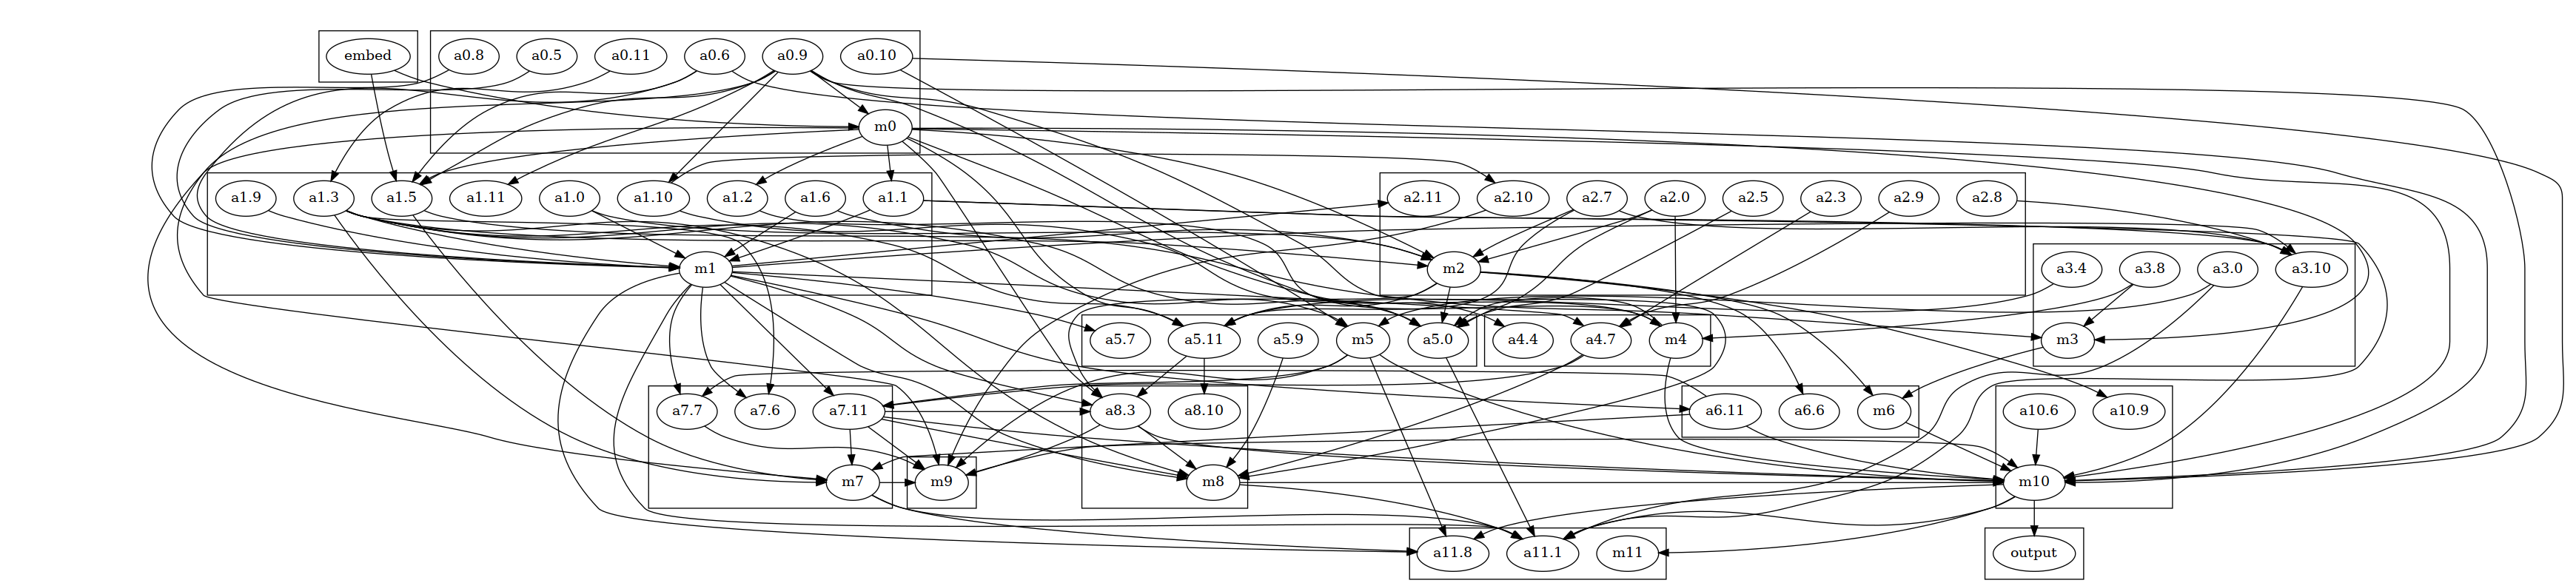

In [20]:
def create_aligned_graph(all_possible_nodes, edges):
    G = pgv.AGraph(strict=False, directed=True)

    # Find the maximum layer number for adjusting the graph
    max_layer = max(layer for layer, _ in all_possible_nodes if isinstance(layer, int))
    nodes_with_edges = set([node for edge in edges for node in edge])
    print(nodes_with_edges)
    # Add nodes and edges to the graph
    # for node in all_possible_nodes:
    #     if node in [edge[0] for edge in edges] or node in [edge[1] for edge in edges]:
    #         G.add_node(node[1], layer=str(max_layer - node[0]))

    for edge in edges:
        G.add_edge(edge[1][1], edge[0][1])

    # Create subgraphs to ensure nodes of the same layer have the same rank
    for layer in range(max_layer, -2, -1):
        with G.subgraph(name=f'cluster_{layer}') as s:
            s.graph_attr['rank'] = 'same'
            for node in nodes_with_edges:
                if node[0] == layer:
                    s.add_node(node[1])

    # Apply layout and render the graph
    G.layout(prog='dot')
    G.draw('aligned_graph.png')
    return Image('aligned_graph.png')

# Call the function with your nodes and edges
flipped_graph_image = create_aligned_graph(all_possible_nodes, edges)

# To display the graph in Jupyter Notebook
flipped_graph_image
